<a href="https://colab.research.google.com/github/Mandar290/Traffic-Volume-Prediction-Using-Weather-Parameters/blob/main/Fusion-Model-for-VQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> <font color="Blue"> Vision Language (V+L) Modelling </font> </center>




### <font color="red"> S1 E1 - Approaching VisualQA(VQA), your V+L Hello World! </font>
###### Catch the [episode on YouTube](https://youtu.be/aGZWjz_K_rg)
----

By [@prithivida](https://twitter.com/prithivida) x [DonkeyStereotype](https://www.donkeystereotype.com/)


## <font color="red"> 1. What does success look like? </font>


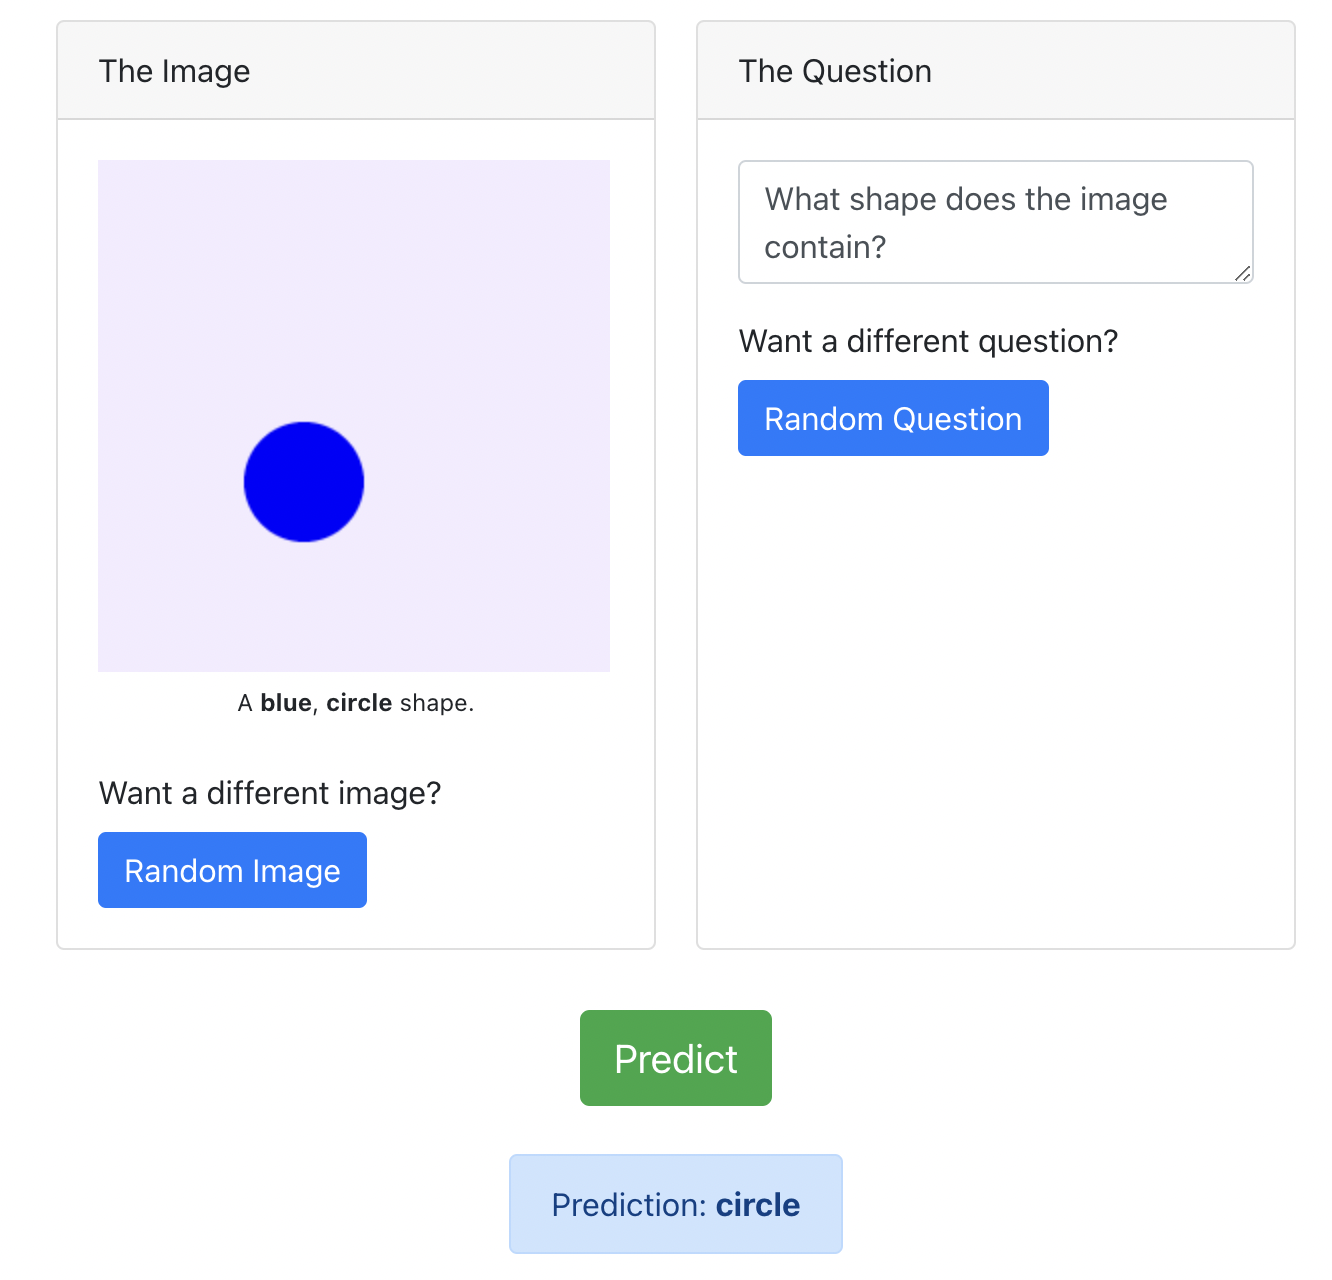

In [ ]:
!pip install -qqq easy-vqa
!pip install -qqq sentence_transformers transformers timm

     |████████████████████████████████| 3.2 MB 14.1 MB/s 
     |████████████████████████████████| 85 kB 4.3 MB/s 
     |████████████████████████████████| 4.4 MB 37.5 MB/s 
     |████████████████████████████████| 512 kB 98.9 MB/s 
     |████████████████████████████████| 1.2 MB 79.4 MB/s 
     |████████████████████████████████| 101 kB 14.0 MB/s 
     |████████████████████████████████| 596 kB 87.1 MB/s 
     |████████████████████████████████| 6.6 MB 78.1 MB/s 


## <font color="red"> 2. Dataset - EasyVQA </font>

In [ ]:
from easy_vqa import get_train_questions, get_test_questions

train_questions, train_answers, train_image_ids = get_train_questions()
test_questions, test_answers, test_image_ids = get_test_questions()

In [ ]:
import pandas as pd
pd.set_option("max_colwidth", None)

def gen_dataframes(questions, answers, image_ids, mode="train"):
    records = []
    for question, answer, image_id in zip(questions, answers, image_ids):
        image_path = f"/usr/local/lib/python3.7/dist-packages/easy_vqa/data/{mode}/images/{image_id}.png"
        records.append({"question" : question, "answer": answer, "image_path": image_path})
    return pd.DataFrame(records)

df =  gen_dataframes(train_questions, train_answers, train_image_ids)
from sklearn.model_selection import train_test_split
df = df.sample(frac=1)
train_df, eval_df = train_test_split(df)
test_df =  gen_dataframes(test_questions, test_answers, test_image_ids, mode="test")

In [ ]:
print(train_df.shape)
print(eval_df.shape)
print(test_df.shape)

(28931, 3)
(9644, 3)
(9673, 3)


In [ ]:
from easy_vqa import get_answers

answers = get_answers()
print("Total labels", len(answers))
label2idx = {answer:i for i, answer in enumerate(answers)}

Total labels 13


In [ ]:
label2idx

{'black': 6,
 'blue': 11,
 'brown': 10,
 'circle': 0,
 'gray': 3,
 'green': 1,
 'no': 12,
 'rectangle': 7,
 'red': 2,
 'teal': 5,
 'triangle': 9,
 'yellow': 8,
 'yes': 4}

In [ ]:
train_df["label"] = train_df["answer"].apply(lambda x: label2idx.get(x))
eval_df["label"] = eval_df["answer"].apply(lambda x: label2idx.get(x))
test_df["label"] = test_df["answer"].apply(lambda x: label2idx.get(x))

In [ ]:
train_df.sample(5)

question     answer  \
37340                      is there a triangle?         no   
29154    does the image contain a yellow shape?         no   
11671      is there a black shape in the image?         no   
3329   is there not a green shape in the image?        yes   
27070                   what is the teal shape?  rectangle   

                                                                       image_path  \
37340  /usr/local/lib/python3.7/dist-packages/easy_vqa/data/train/images/3872.png   
29154  /usr/local/lib/python3.7/dist-packages/easy_vqa/data/train/images/3031.png   
11671  /usr/local/lib/python3.7/dist-packages/easy_vqa/data/train/images/1209.png   
3329    /usr/local/lib/python3.7/dist-packages/easy_vqa/data/train/images/339.png   
27070  /usr/local/lib/python3.7/dist-packages/easy_vqa/data/train/images/2818.png   

       label  
37340     12  
29154     12  
11671     12  
3329       4  
27070      7

## <font color="red"> 3. A look at V+L Feature backbones </font>

**[Important]** <font color="blue">  A friendly reminder - The code might look less elegant to keep the feature backbones outside of the VQA model we are going to build. </font> but we are going to freeze all layers of the backbones and use them as pure feature extractors. So we don't need them as a part of our network. In the subsequent episodes as and when we need to finetune we will make the featue backbones as a part of the network. (If you dont follow this at the moment don't worry)

In [ ]:
from transformers import AutoTokenizer, AutoFeatureExtractor, AutoModel
import torchvision.transforms as T
import torch
import timm


""" Fusing Transformers """
device = "cuda:0" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text_encoder = AutoModel.from_pretrained("bert-base-uncased")
for p in text_encoder.parameters():
    p.requires_grad = False


image_processor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
image_encoder = AutoModel.from_pretrained("google/vit-base-patch16-224-in21k")

""" Fusing CNNs and Transformers """
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
# image_encoder = timm.create_model("resnet50d", pretrained=True,  num_classes=0)
# resize_transform = T.Resize((224, 224))

for p in image_encoder.parameters():
    p.requires_grad = False


image_encoder.to(device)
text_encoder.to(device)

print()


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

## <font color="red"> 4 - Stitch torch dataset w/feature backbones </font>

In [ ]:
from PIL import Image
from tqdm import tqdm
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms

class EasyQADataset(Dataset):

    def __init__(self,df,
                 image_encoder,
                 text_encoder,
                 image_processor,
                 tokenizer,
              ):
        self.df = df
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.image_processor = image_processor
        self.tokenizer = tokenizer


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        image_file = self.df["image_path"][idx]
        question = self.df['question'][idx]
        image = Image.open(image_file).convert("RGB")
        label = self.df['label'][idx]

        """ When CNNs are used for V backbone"""

        # image = resize_transform(image)
        # image_inputs = T.ToTensor()(image).unsqueeze_(0)
        # image_inputs = image_inputs.to(device)
        # image_outputs = self.image_encoder(image_inputs)
        # image_embedding = image_outputs[0]
        # image_embedding = image_embedding.detach()
        #print("Image emb", image_embedding.shape)

        """ When Transformers are used for V backbone"""
        image_inputs = self.image_processor(image, return_tensors="pt")
        image_inputs = {k:v.to(device) for k,v in image_inputs.items()}
        image_outputs = self.image_encoder(**image_inputs)
        image_embedding = image_outputs.pooler_output
        image_embedding = image_embedding.view(-1)
        image_embedding = image_embedding.detach()
        # print("Image emb", image_embedding.shape)

        text_inputs = self.tokenizer(question, return_tensors="pt")
        text_inputs = {k:v.to(device) for k,v in text_inputs.items()}
        text_outputs = self.text_encoder(**text_inputs)
        text_embedding = text_outputs.pooler_output # You can experiment with this or raw CLS embedding below
        #text_embedding = text_outputs.last_hidden_state[:,0,:] # Raw CLS embedding
        text_embedding = text_embedding.view(-1)
        text_embedding = text_embedding.detach()
        # print("Text emb", text_embedding.shape)

        encoding={}
        encoding["image_emb"] = image_embedding
        encoding["text_emb"] = text_embedding
        encoding["label"] = torch.tensor(label)

        return encoding

In [ ]:
train_df.reset_index(drop=True, inplace=True)
eval_df.reset_index(drop=True, inplace=True)

train_dataset = EasyQADataset(
                           df=train_df,
                           image_encoder = image_encoder,
                           text_encoder = text_encoder,
                           tokenizer = tokenizer,
                           image_processor = image_processor, # Pass None when using CNNs
                           )

eval_dataset = EasyQADataset(
                           df=eval_df,
                           image_encoder = image_encoder,
                           text_encoder = text_encoder,
                           tokenizer = tokenizer,
                           image_processor = image_processor,# Pass None when using CNNs
                          )

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32
eval_batch_size = 32
dataloader_train = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=batch_size)
dataloader_validation = DataLoader(eval_dataset,
                                   sampler=SequentialSampler(eval_dataset),
                                   batch_size=eval_batch_size)

In [ ]:
from sklearn.metrics import accuracy_score

def accuracy_score_func(preds, labels):
    return accuracy_score(labels, preds)

## <font color="red"> 5. A Simple PyTorch Training loop </font>

**[Important]** <font color="blue">  Again, A friendly reminder - the code might look less elegant, but thats by choice. </font> In the subsequent episodes will move the loss handling inside the model forward().

In [ ]:
import random
from torch import nn
from tqdm.notebook import tqdm
import numpy as np
import requests

criterion = nn.CrossEntropyLoss()

def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals, confidence = [], [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch.values())

        inputs = {'image_emb':  batch[0],'text_emb': batch[1]}

        with torch.no_grad():
            outputs = model(**inputs)

        labels =  batch[2]
        loss = criterion(outputs.view(-1, 13), labels.view(-1))
        loss_val_total += loss.item()

        probs   = torch.max(outputs.softmax(dim=1), dim=-1)[0].detach().cpu().numpy()
        outputs = outputs.argmax(-1)
        logits = outputs.detach().cpu().numpy()
        label_ids = labels.cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        confidence.append(probs)

    loss_val_avg = loss_val_total/len(dataloader_val)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    confidence = np.concatenate(confidence, axis=0)

    return loss_val_avg, predictions, true_vals, confidence

def train():

  train_history = open("/content/models/train_history.csv", "w")
  log_hdr  = "Epoch, train_loss, train_acc, val_loss, val_acc"
  train_history.write(log_hdr  + "\n")
  train_f1s = []
  val_f1s = []
  train_losses = []
  val_losses = []
  min_val_loss = -1
  max_auc_score = 0
  epochs_no_improve = 0
  early_stopping_epoch = 3
  early_stop = False

  for epoch in tqdm(range(1, epochs+1)):

      model.train()
      loss_train_total = 0
      train_predictions, train_true_vals = [], []

      progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)

      for batch in progress_bar:
          model.zero_grad()
          batch = tuple(b.to(device) for b in batch.values())

          inputs = {'image_emb':  batch[0],'text_emb': batch[1]}
          labels =  batch[2]

          outputs = model(**inputs)
          loss = criterion(outputs.view(-1, 13), labels.view(-1))
          loss_train_total += loss.item()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          logits = outputs.argmax(-1)
          logits = logits.detach().cpu().numpy()
          label_ids = labels.cpu().numpy()
          train_predictions.append(logits)
          train_true_vals.append(label_ids)

          optimizer.step()
          scheduler.step()

          progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})



      train_predictions = np.concatenate(train_predictions, axis=0)
      train_true_vals = np.concatenate(train_true_vals, axis=0)

      tqdm.write(f'\nEpoch {epoch}')
      loss_train_avg = loss_train_total/len(dataloader_train)
      tqdm.write(f'Training loss: {loss_train_avg}')
      train_f1 = accuracy_score_func(train_predictions, train_true_vals)
      tqdm.write(f'Train Acc: {train_f1}')

      val_loss, predictions, true_vals,_ = evaluate(dataloader_validation)
      val_f1 = accuracy_score_func(predictions, true_vals)
      tqdm.write(f'Validation loss: {val_loss}')
      tqdm.write(f'Val Acc: {val_f1}')

      if val_f1 >= max_auc_score:
          tqdm.write('\nSaving best model')
          torch.save(model.state_dict(), f'/content/models/easyvqa_finetuned_epoch_{epoch}.model')
          max_auc_score = val_f1

      train_losses.append(loss_train_avg)
      val_losses.append(val_loss)
      train_f1s.append(train_f1)
      val_f1s.append(val_f1)
      log_str  = "{}, {}, {}, {}, {}".format(epoch, loss_train_avg, train_f1, val_loss, val_f1)
      train_history.write(log_str + "\n")

      if min_val_loss < 0:
          min_val_loss = val_loss
      else:
        if val_loss < min_val_loss:
            min_val_loss = val_loss
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_epoch:
                early_stop = True
                break
            else:
                continue


  if early_stop:
    print("Early Stopping activated at epoch -", epoch )
    print("Use the checkpoint at epoch - ", epoch - early_stopping_epoch)

  train_history.close()
  return train_losses, val_losses

## <font color="red"> 6a. Model - An Early Fusion Network using CNN as V backbone and Transformers as L backbone </font>

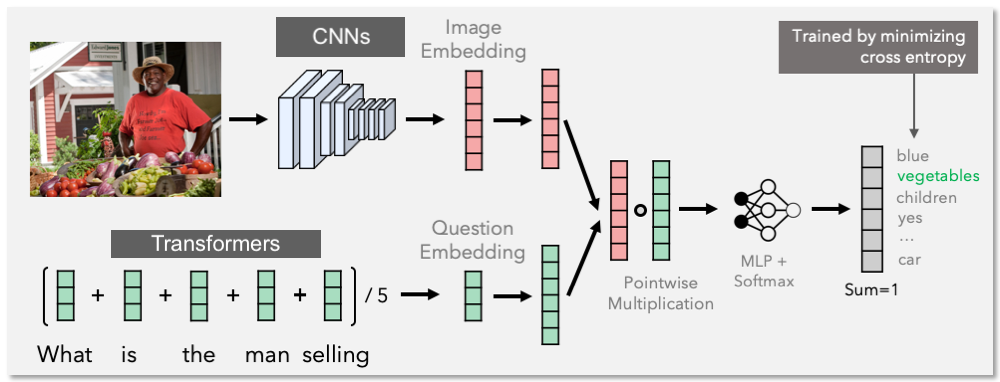

In [ ]:
class EasyQAEarlyFusionNetwork(nn.Module):

    def __init__(self, hyperparms=None):

        super(EasyQAEarlyFusionNetwork, self).__init__()
        self.dropout = nn.Dropout(0.3)
        self.vision_projection = nn.Linear(2048, 768)
        self.text_projection = nn.Linear(512, 768)
        self.fc1 = nn.Linear(768, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.classifier = nn.Linear(256, 13)
        W = torch.Tensor(768, 768)
        self.W = nn.Parameter(W)
        self.relu_f = nn.ReLU()
        # initialize weight matrices
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))

    def forward(self, image_emb, text_emb):

        x1 = image_emb
        x1 = torch.nn.functional.normalize(x1, p=2, dim=1)
        Xv = self.relu_f(self.vision_projection(x1))

        x2 = text_emb
        x2 = torch.nn.functional.normalize(x2, p=2, dim=1)
        Xt = self.relu_f(self.text_projection(x2))

        Xvt = Xv * Xt
        Xvt = self.relu_f(torch.mm(Xvt, self.W.t()))

        Xvt = self.fc1(Xvt)
        Xvt = self.bn1(Xvt)
        Xvt = self.dropout(Xvt)
        Xvt = self.classifier(Xvt)

        return Xvt

## <font color="red"> 6b. Model - A Mid Fusion Network using Transformers as V and L backbones </font>

In [ ]:
class EasyQAMidFusionNetwork(nn.Module):

    def __init__(self, hyperparms=None):

        super(EasyQAMidFusionNetwork, self).__init__()
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(768, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.classifier = nn.Linear(256, 13)
        W = torch.Tensor(768, 768)
        self.W = nn.Parameter(W)
        self.relu_f = nn.ReLU()
        # initialize weight matrices
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))

    def forward(self, image_emb, text_emb):

        x1 = image_emb
        Xv = torch.nn.functional.normalize(x1, p=2, dim=1)

        x2 = text_emb
        Xt = torch.nn.functional.normalize(x2, p=2, dim=1)

        Xvt = Xv * Xt
        Xvt = self.relu_f(torch.mm(Xvt, self.W.t()))

        Xvt = self.fc1(Xvt)
        Xvt = self.bn1(Xvt)
        Xvt = self.dropout(Xvt)
        Xvt = self.classifier(Xvt)

        return Xvt

# <font color="red"> Terminology Hijack (or more directly Bastardization of Terminology): </font>

**A note on Early, Late and Mid Fusion**:

Traditionally in a pretransformer world (i.e. When vision was in pretranformer or CNN only era) Early Fusion referred to **feature fusion** and Late fusion referred to **decision fusion**

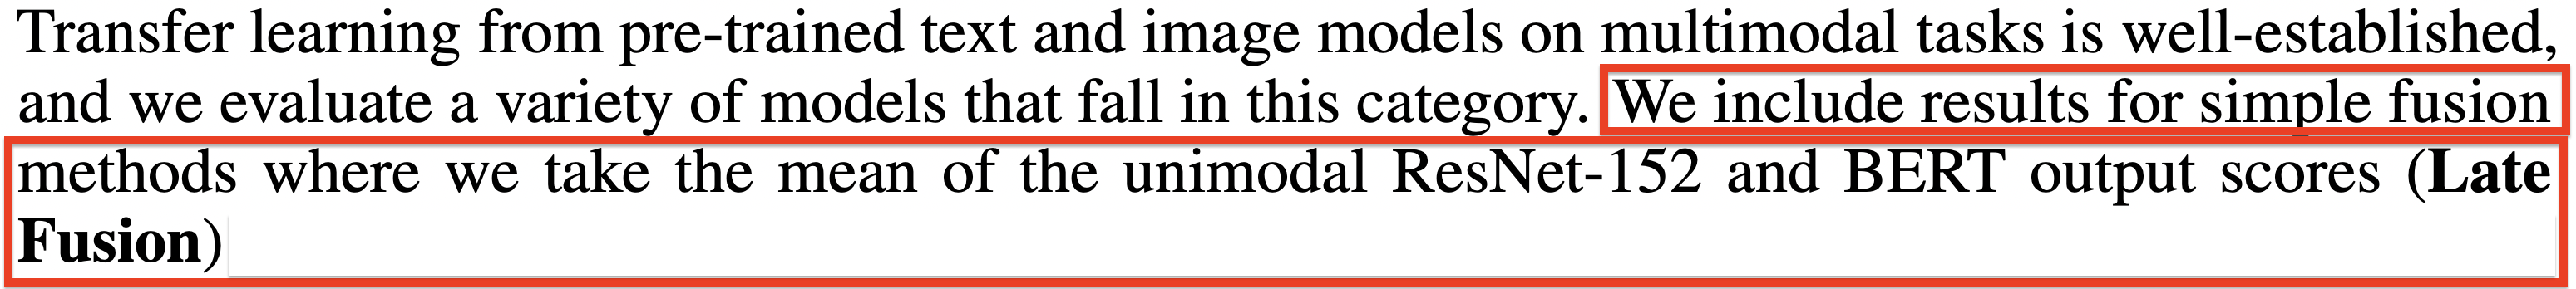

When Vision moved to a Post-transformer world i.e both Vision backbones and Language backbones are transformers and they both have encoders. So based on **how and when** the encoders can interact the notion of fusion has been re-branded as below. If the encoders don't interact then it is termed late fusion. So in summary the pre-transformer world Early Fusion is the Post-transformer world Late fusion.

![Alt Text](https://lh3.googleusercontent.com/syHWoS-2bHO4qQVe4Q0I8g7pol9c_yZI63d3idE2PXL9Xgq_nBFzKVedw8GnQ181mHqzQHJ9VupJTavSqFvZ0ViGs146rkwZK8zICD-LfMzjgQtHzf2jFMjNlsB75PpDVTAE8QwHeQ=w640-h182)

In [ ]:
#@title
from IPython.display import IFrame
IFrame(src="https://giphy.com/embed/XcAa52ejGuNqdb5SFQ", width="1000", height="300", frameBorder="0")

# <font color="red"> A recent Vision Language Pretraining review captures only 2 architecture styles, but writes-off custom fusion. </font>



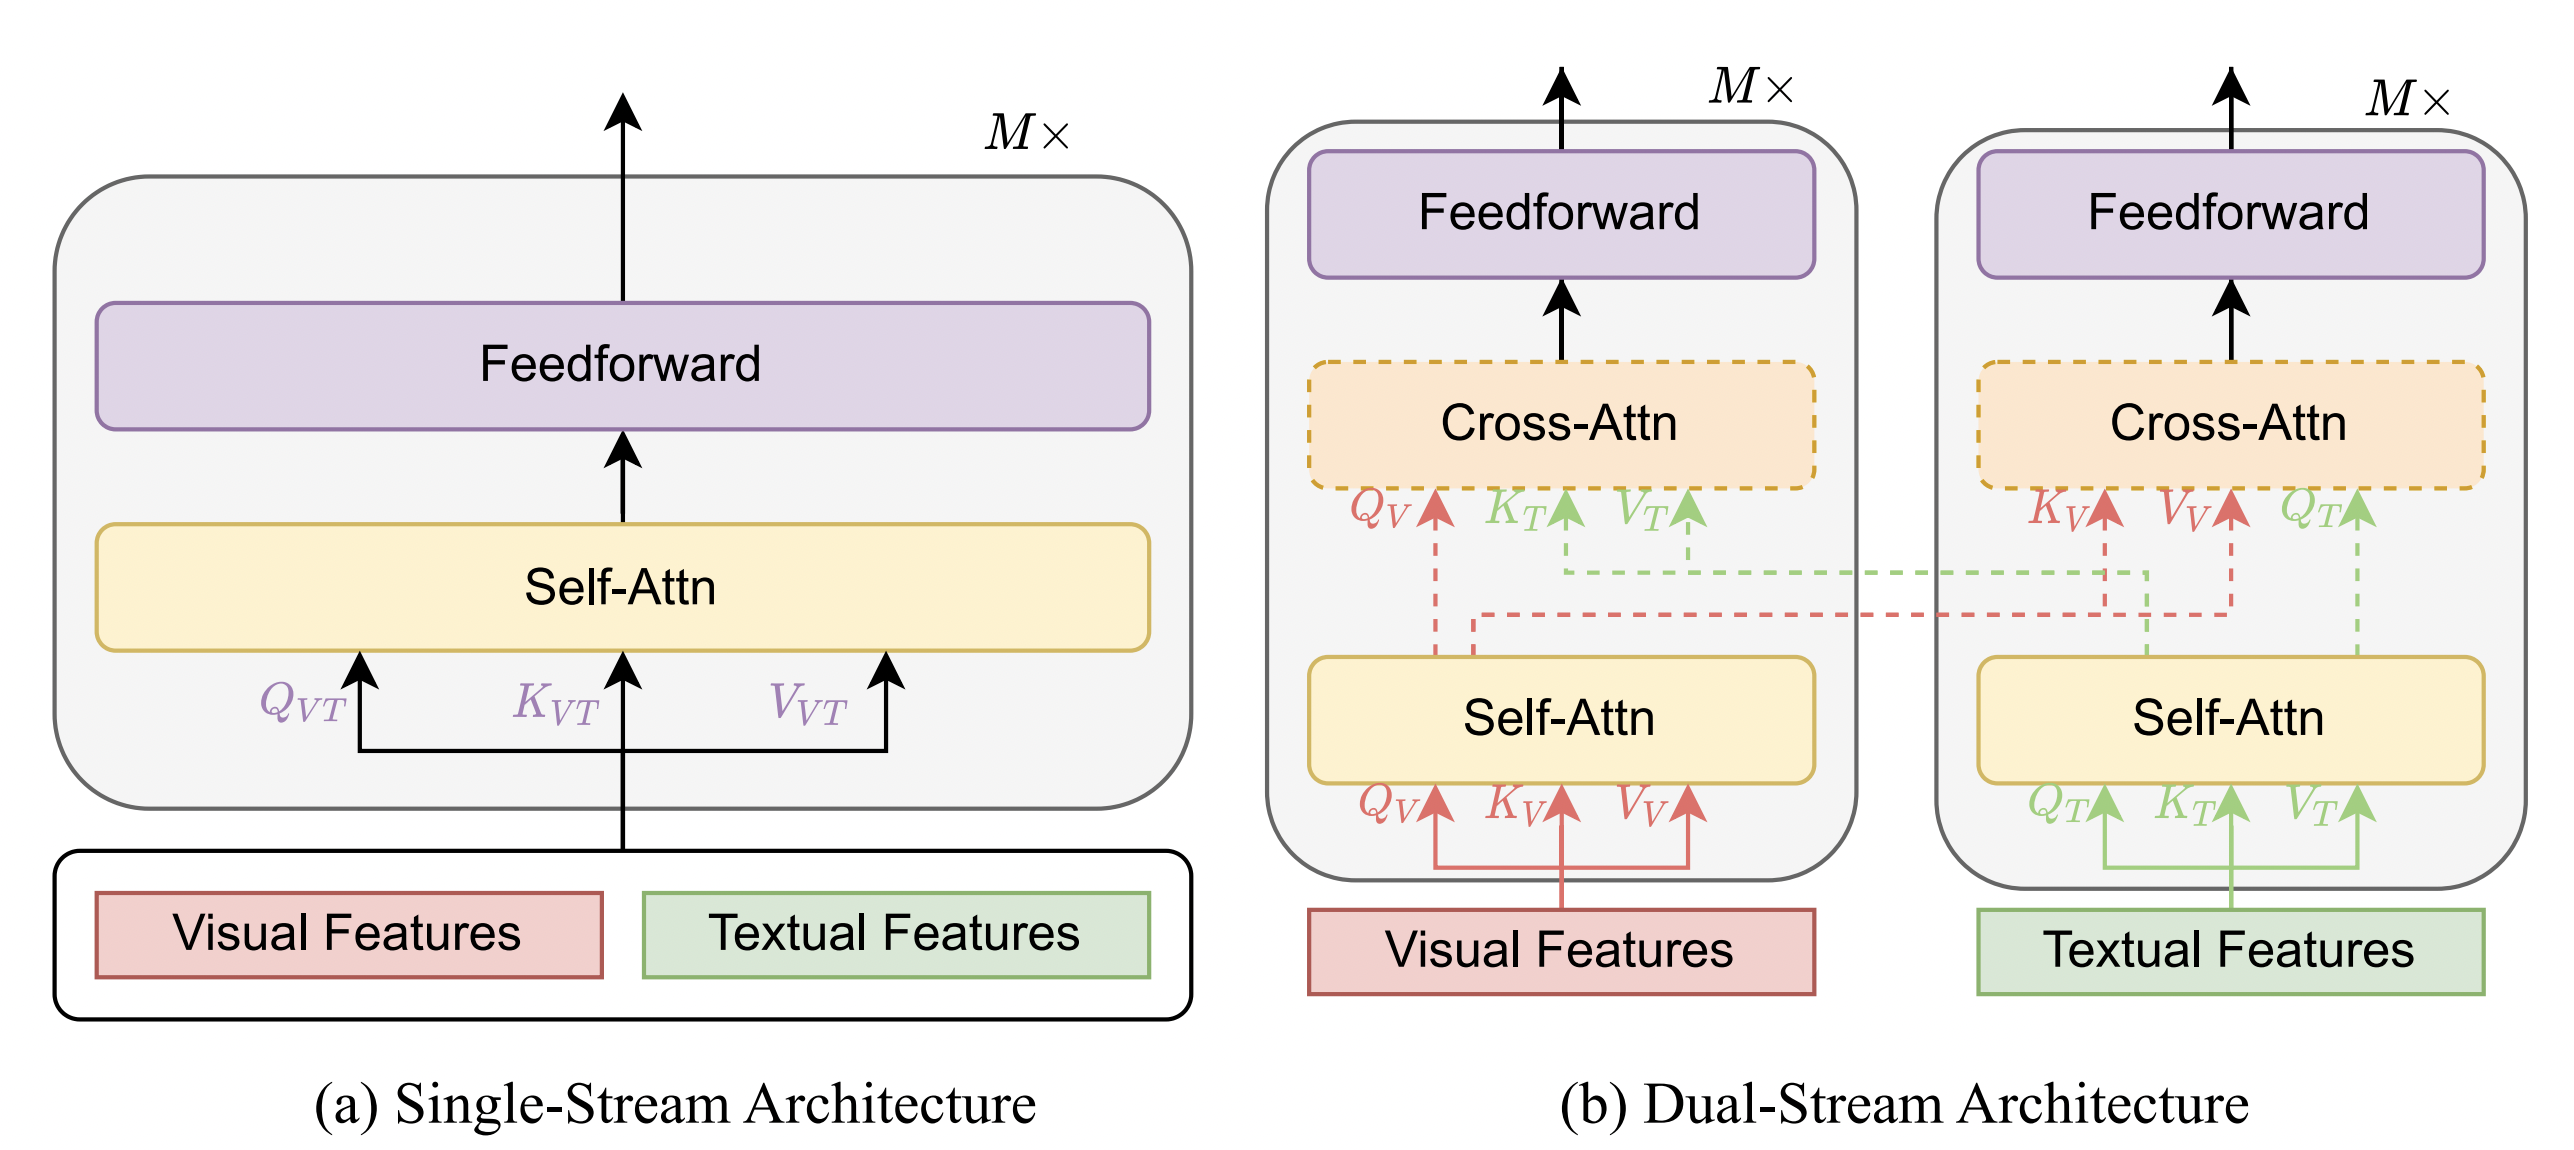

# <font color="red"> Long list of *Almost* All VLP Models </font>



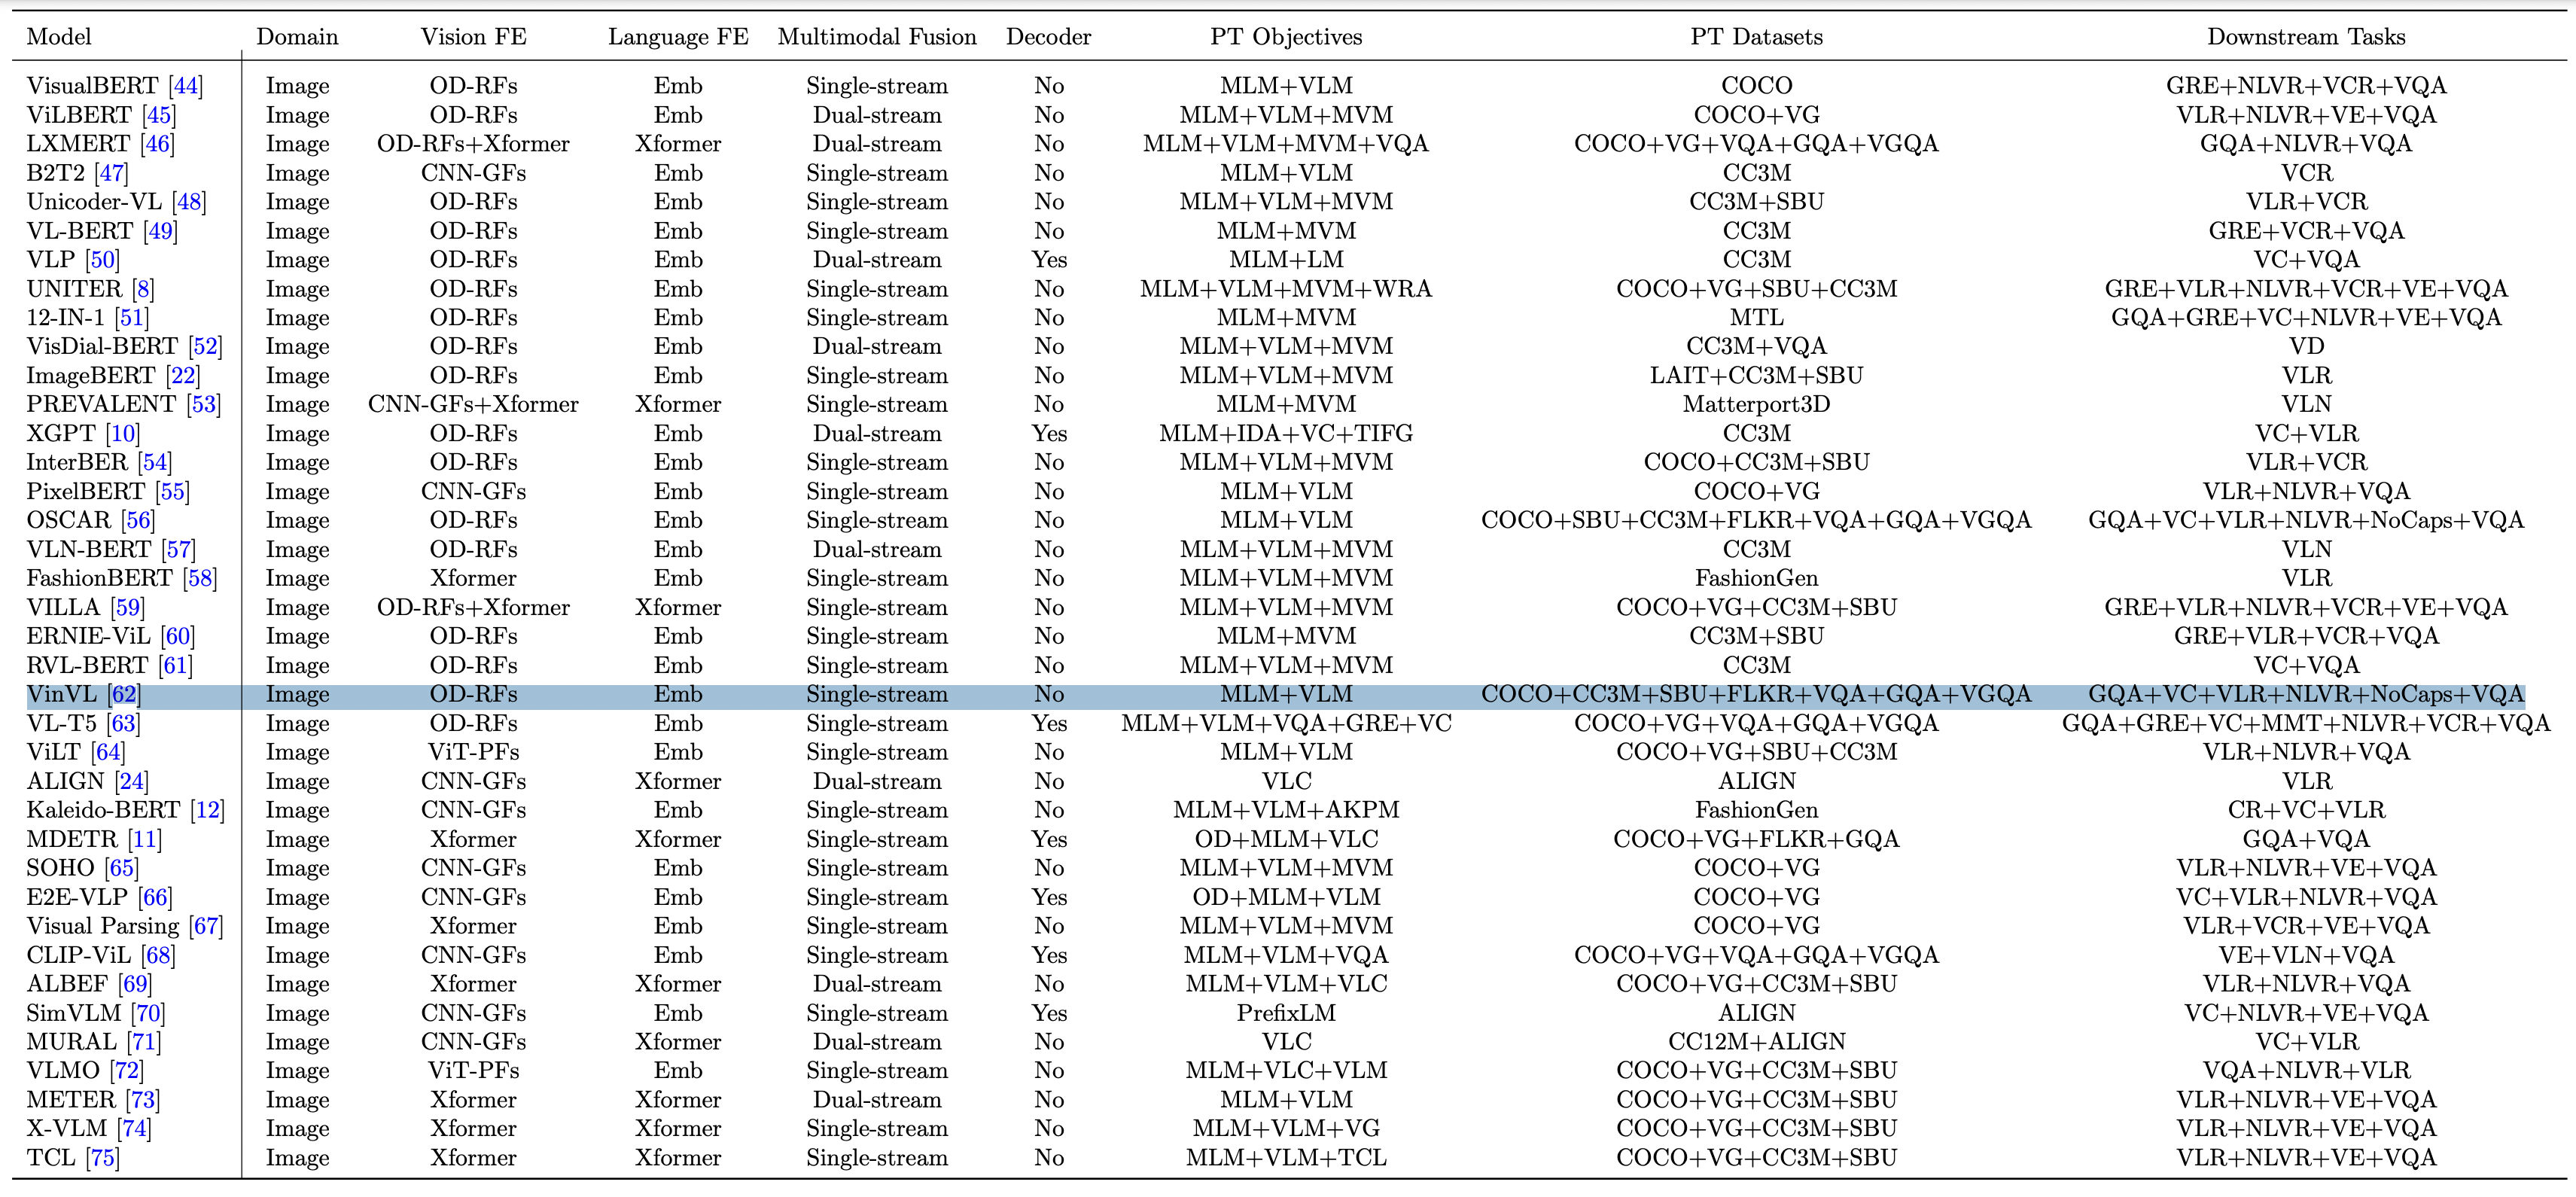

In [ ]:
#@title
from IPython.display import IFrame
IFrame(src="https://giphy.com/embed/j9djzcMmzg8ow", width="1000", height="300", frameBorder="0")

In [ ]:
torch.cuda.empty_cache()
model = EasyQAEarlyFusionNetwork()
model.to(device)

EasyQAEarlyFusionNetwork(
  (dropout): Dropout(p=0.3, inplace=False)
  (vision_projection): Linear(in_features=2048, out_features=768, bias=True)
  (text_projection): Linear(in_features=512, out_features=768, bias=True)
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Linear(in_features=256, out_features=13, bias=True)
  (relu_f): ReLU()
)

In [ ]:
torch.cuda.empty_cache()
model = EasyQAMidFusionNetwork()
model.to(device)

EasyQAMidFusionNetwork(
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Linear(in_features=256, out_features=13, bias=True)
  (relu_f): ReLU()
)

In [ ]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

optimizer = AdamW(model.parameters(),
                  lr=5e-5,
                  weight_decay = 1e-5,
                  eps=1e-8
                  )

epochs = 10
train_steps=20000
print("train_steps", train_steps)
warm_steps = train_steps * 0.1
print("warm_steps", warm_steps)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warm_steps,
                                            num_training_steps=train_steps)

train_steps 20000
warm_steps 2000.0


# <font color="red"> 7a. Train the early fusion network. </font>



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/905 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.9431136534358915
Train Acc: 0.3417441498738378
Validation loss: 0.900954245928897
Val Acc: 0.6672542513479884

Saving best model


Epoch 2:   0%|          | 0/905 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.8398510333253534
Train Acc: 0.6994573295081401
Validation loss: 0.6670724214702253
Val Acc: 0.7559104106180008

Saving best model


Epoch 3:   0%|          | 0/905 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.6763040906816556
Train Acc: 0.7534132936988006
Validation loss: 0.6034645883255447
Val Acc: 0.7782040647034425

Saving best model


Epoch 4:   0%|          | 0/905 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.5732837230461079
Train Acc: 0.7904324081435139
Validation loss: 0.47745987526233624
Val Acc: 0.8272501036914144

Saving best model


Epoch 5:   0%|          | 0/905 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.44930406222685926
Train Acc: 0.839687532404687
Validation loss: 0.3901944677808032
Val Acc: 0.8624014931563666

Saving best model


Epoch 6:   0%|          | 0/905 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.35638364539455974
Train Acc: 0.888147661677785
Validation loss: 0.3102024401359211
Val Acc: 0.9133139776026545

Saving best model


Epoch 7:   0%|          | 0/905 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.27732333880926363
Train Acc: 0.9192907262106391
Validation loss: 0.2747797804162992
Val Acc: 0.9235794276233927

Saving best model


Epoch 8:   0%|          | 0/905 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.2294618960490543
Train Acc: 0.9277937160830942
Validation loss: 0.2292929987688333
Val Acc: 0.9265864786395687

Saving best model


Epoch 9:   0%|          | 0/905 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.18991000507212147
Train Acc: 0.9376793059348104
Validation loss: 0.23049450470813063
Val Acc: 0.9230609705516383


Epoch 10:   0%|          | 0/905 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.15601462756196108
Train Acc: 0.9469427257958591
Validation loss: 0.18594902322091014
Val Acc: 0.9371630029033596

Saving best model


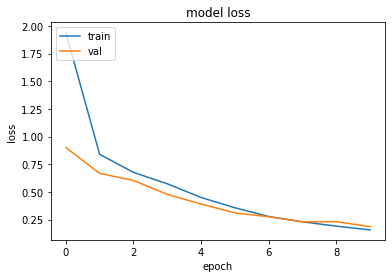

In [ ]:
from matplotlib import pyplot as plt
try:
  !rm -rf /content/models
  !mkdir /content/models
  train_losses, val_losses =  train()
  torch.cuda.empty_cache()
  plt.plot(train_losses)
  plt.plot(val_losses)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
except:
    print("Sh*t happens !, if you are a self-respecting human, don't rote copy this. Catch the exception and write a nice message")

# <font color="red"> 7b. Train the mid fusion network. </font>



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/905 [00:00<?, ?it/s]


Epoch 1
Training loss: 2.4214471569377416
Train Acc: 0.20642217690366735
Validation loss: 2.0274744929856814
Val Acc: 0.40481128162588137

Saving best model


Epoch 2:   0%|          | 0/905 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.5851240470923114
Train Acc: 0.5785489613217656
Validation loss: 1.0704591384786644
Val Acc: 0.7015761094981335

Saving best model


Epoch 3:   0%|          | 0/905 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.9119243326766715
Train Acc: 0.7170509142442363
Validation loss: 0.6818431260569996
Val Acc: 0.7581916217337205

Saving best model


Epoch 4:   0%|          | 0/905 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.6954168795880692
Train Acc: 0.7617434585738482
Validation loss: 0.5682179365331763
Val Acc: 0.8122148486105351

Saving best model


Epoch 5:   0%|          | 0/905 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.5925359403889482
Train Acc: 0.8030486329542705
Validation loss: 0.491503563444346
Val Acc: 0.8488179178763998

Saving best model


Epoch 6:   0%|          | 0/905 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.5224820040042888
Train Acc: 0.83204866751927
Validation loss: 0.43349853532993243
Val Acc: 0.8638531729572791

Saving best model


Epoch 7:   0%|          | 0/905 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.46347601957084067
Train Acc: 0.8480868272786976
Validation loss: 0.409876184451659
Val Acc: 0.8667565325591041

Saving best model


Epoch 8:   0%|          | 0/905 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.42745131641132394
Train Acc: 0.8545159171822613
Validation loss: 0.38297313821828916
Val Acc: 0.8678971381169639

Saving best model


Epoch 9:   0%|          | 0/905 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.4034934931532454
Train Acc: 0.8579032871314507
Validation loss: 0.37198305174412316
Val Acc: 0.8714226462048942

Saving best model


Epoch 10:   0%|          | 0/905 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.38831471802450673
Train Acc: 0.8614980470775293
Validation loss: 0.3561316124650816
Val Acc: 0.8702820406470344


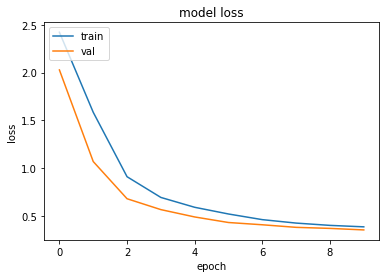

In [ ]:
from matplotlib import pyplot as plt
try:
  !rm -rf /content/models
  !mkdir /content/models
  train_losses, val_losses =  train()
  torch.cuda.empty_cache()
  plt.plot(train_losses)
  plt.plot(val_losses)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
except:
    print("Sh*t happens !, if you are a self-respecting human, don't rote copy this. Catch the exception and write a nice message")

# <font color="red"> 8. Let's see if the model(s) have learned something at all ? Some Key takeaways before that </font>


### - **All tasks are not made equal**
 - Modality interactions aka fusing depends on tasks, for instance in VQA Image weighs more than text, whereas CLIP is task where we need to weigh both modalities equally.You will learn
  - Multiple fusion techniques.
  - How to pick the right Modality experts for a given task.
  - The nuances of tasks and how to tweak your fusions accordingly as progress

### - **Tasks themselves have increasing levels of difficulty.**
  - VQA 1/2 (Needs Regions or objects of Images and may be attention), Things can get tricky look at the image below.
  - OK-VQA (Needs External Knowledege)
  - GQA
  - TVQA (Is Video Question Answering)


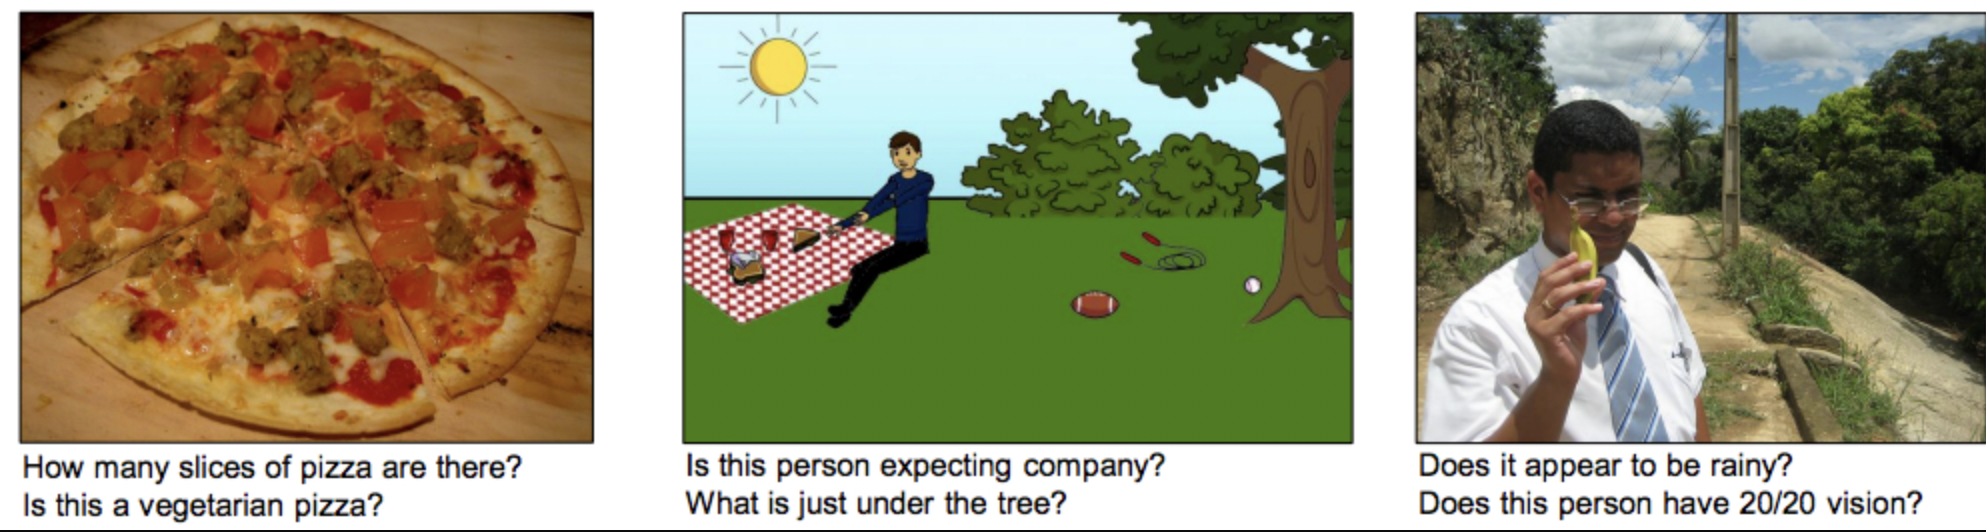

# <font color="red"> What you can expect from this tutorial series in the coming weeks/months ? </font>

**Each episode in this series will take a task/dataset and build a useful model step-by-step.**

**Sneak Peak into what we will be covering**
- Generative Tasks (Fx Captioning)
- Exotic Tasks  (Fx Vision Language Navigation, MultiModal Translation)
- Adding Multilingual to Multimodal.
- Learning a Joint V+L embedding.
- Improve the modality interactions.
- Adding attentions to interactions.
- Comparing CNN backbones Vs Transformer based Backbones.

...

all the way upto training Diffusion Models (like ImageGEN)

- For Text to Image generation (like DALL-E or ImageGEN)
- For Text to Video generation




-----
# <font color="red"> After season finale... You will become ? ⬇ </font>

In [ ]:
#@title
from IPython.display import IFrame
IFrame(src="https://giphy.com/embed/3oEjHNCWpx4iQYytAA", width="1000", height="300", frameBorder="0")

# <font color="red"> 9. Run inference on the test data </font>

In [ ]:
test_dataset = EasyQADataset(
                           df=test_df,
                           image_encoder = image_encoder,
                           text_encoder = text_encoder,
                           tokenizer = tokenizer,
                           image_processor = image_processor
                           )

In [ ]:
device = "cuda:0"
model.load_state_dict(torch.load('/content/models/easyvqa_finetuned_epoch_9.model'))
model.to(device)

EasyQAMidFusionNetwork(
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Linear(in_features=256, out_features=13, bias=True)
  (relu_f): ReLU()
)

In [ ]:
dataloader_test = DataLoader(test_dataset,
                            sampler=SequentialSampler(test_dataset),
                            batch_size=128)

_, preds, truths, confidence = evaluate(dataloader_test)

# <font color="red"> 10. Moment of Truth :-)? </font>

In [ ]:
print("Test Acc with Resnet50d: " , accuracy_score_func(preds,truths))

Test Acc with Resnet50d:  0.9255660084772046


In [ ]:
print("Test Acc with ViT: " , accuracy_score_func(preds,truths))

Test Acc with ViT:  0.8707743202729247


In [ ]:
test_results_df = pd.concat([test_df, pd.DataFrame(preds, columns=["preds"]), pd.DataFrame(truths, columns=["gt"]), pd.DataFrame(confidence, columns=["confidence"])], axis=1)

In [ ]:
test_results_df.sample(5)

question     answer  \
1744      is there a green shape in the image?         no   
1240                    what shape is present?  rectangle   
4637  does the image not contain a teal shape?        yes   
6227                   is no triangle present?        yes   
9263                    what shape is present?  rectangle   

                                                                    image_path  \
1744  /usr/local/lib/python3.7/dist-packages/easy_vqa/data/test/images/177.png   
1240  /usr/local/lib/python3.7/dist-packages/easy_vqa/data/test/images/130.png   
4637  /usr/local/lib/python3.7/dist-packages/easy_vqa/data/test/images/477.png   
6227  /usr/local/lib/python3.7/dist-packages/easy_vqa/data/test/images/640.png   
9263  /usr/local/lib/python3.7/dist-packages/easy_vqa/data/test/images/956.png   

      label  preds  gt  confidence  
1744     12     12  12    0.951256  
1240      7      7   7    0.998722  
4637      4      4   4    0.948039  
6227      4      4   4    0.996698  
9263      7      7   7    0.999920

# <font color="red"> Is the Model Overconfident when its wrong? </font>

In [ ]:
test_results_df[(test_results_df["preds"] != test_results_df["gt"]) & (test_results_df["confidence"] >= 0.90)].shape

(197, 7)

In [ ]:
label2idx

{'black': 6,
 'blue': 11,
 'brown': 10,
 'circle': 0,
 'gray': 3,
 'green': 1,
 'no': 12,
 'rectangle': 7,
 'red': 2,
 'teal': 5,
 'triangle': 9,
 'yellow': 8,
 'yes': 4}

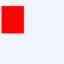

In [ ]:
from PIL import Image
Image.open("/usr/local/lib/python3.7/dist-packages/easy_vqa/data/test/images/130.png")

# <font color="red"> Introducing LiteFuse: <font color="black"> A library that will let you train V+L models using some of the techniques shown above for various downstream tasks. </font></font>

You could,

- Get Involved (Will drop a note, when we are ready for PRs)
- Pre-star the repo (Will drop a note when the library is public)

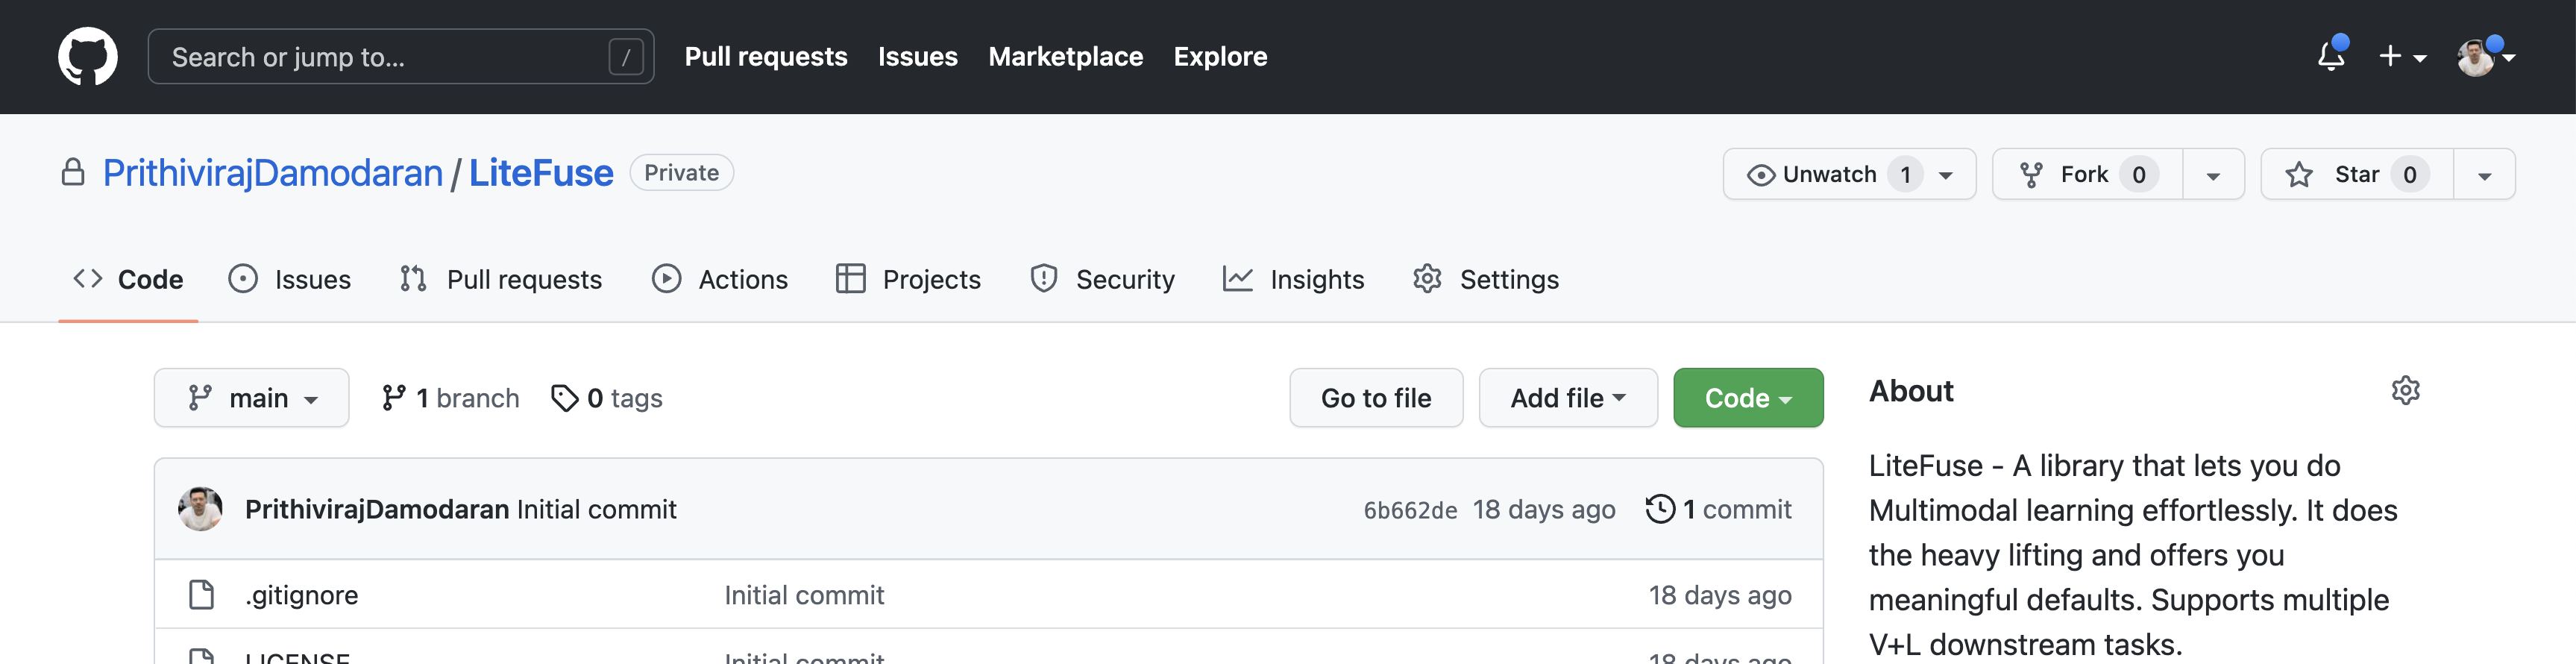

-----
# <font color="red"> If You Know You Know 😉 </font>

In [ ]:
#@title
from IPython.display import IFrame
IFrame(src="https://2.bp.blogspot.com/-All4KUQFxjM/WPSIOh_BGgI/AAAAAAAAPEA/XJpsgJOxwEkBlwydBGtN27c5kk2jjw5wgCLcB/s1600/mission-impossible-ghost-protocol-paula-patton-lighting-the-fuse-600x337.gif", width="1000", height="300", frameBorder="0")
